# Introduction

This my first pass at trying to check if my star parameters worked.

I used the version of star and the annotation files included in the 10x cellranger-arc archive as the closest check I could manage.

I had used STAR 2.7.8a for some of my other tests as the released version of 2.7.9a had a bug. But unforutnately 2.7.8a crashed with a double free error. (And illegal instruction on some other machines, probably older).

So I had to use the prebuilt STAR from tag 2.7.9a_2021-06-25

In [1]:
import scipy
import pandas
import scanpy
import numpy
from pathlib import Path
from matplotlib import pyplot
import sys
import pysam
from collections import Counter

In [2]:
pwd

'/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/adrenal/ENCSR724KET_16f_nuc'

In [3]:
project_root = Path("../..").absolute()
if str(project_root) not in sys.path:
    sys.path.append(str(project_root))
from common import compute_spearman_anndata

In [4]:
def scanpy_load_solo278a_mtx(analysis_dir, quantification="Gene", mode="filtered"):
    assert mode in ["filtered", "raw"], "STAR Solo only produces raw or filtered files"
    assert quantification in ["Gene", "GeneFull", "SJ"]

    analysis_dir = Path(analysis_dir)
    feature_name = "features.tsv"
    
    solo_dir = analysis_dir / "Solo.out" / quantification / mode
    solo = scanpy.read_mtx(solo_dir / "matrix.mtx").T
    solo_vars = pandas.read_csv(
        solo_dir / feature_name, header=None, sep="\t"
    ).values.T
    solo_obs = pandas.read_csv(
        solo_dir / "barcodes.tsv", header=None, sep="\t"
    ).values.T
    solo.obs_names = solo_obs[0]
    solo.var_names = solo_vars[0]

    solo.obs["counts"] = solo.X.sum(axis=1)
    solo.obs["ngenes"] = numpy.array((solo.X > 0).sum(axis=1))

    return solo



In [5]:
tenx_root = Path('ENCSR724KET_cr-arc')
tenx_raw_path = tenx_root / 'outs' / 'raw_feature_bc_matrix'
tenx_filtered_path = tenx_root / 'outs' / 'filtered_feature_bc_matrix'

In [6]:
tenx_filtered = scanpy.read_10x_mtx(tenx_filtered_path, var_names='gene_ids')
tenx_filtered.obs_names = [x[:-2] for x in tenx_filtered.obs_names]

In [7]:
solo278a_root = Path("starsolo_2.7.9a_2021-06-25_encode+cr")
solo278a_gene = scanpy_load_solo278a_mtx(solo278a_root, "Gene", "filtered")
solo278a_genefull = scanpy_load_solo278a_mtx(solo278a_root, "GeneFull", "filtered")

In [8]:
print("tenx filtered", tenx_filtered.shape, tenx_filtered.X.sum())
print("solo gene", solo278a_gene.shape, solo278a_gene.X.sum())
print("solo genefull", solo278a_genefull.shape, solo278a_genefull.X.sum())

tenx filtered (13650, 36601) 80119070.0
solo gene (14401, 36601) 41423616.0
solo genefull (15900, 36601) 110533290.0


In [9]:
common_barcodes = [ x for x in tenx_filtered.obs_names if x in set(tenx_filtered.obs_names).intersection(solo278a_gene.obs_names)]

In [10]:
solo278a_filtered_gene = solo278a_gene[common_barcodes,:]
solo278a_filtered_gene.shape, solo278a_filtered_gene.X.sum()

((12838, 36601), 39420270.0)

In [11]:
solo278a_filtered_gene.X.sum(axis=1).shape

(12838, 1)

In [12]:
tenx_common = tenx_filtered[common_barcodes,:]

In [13]:
filtered_cors = compute_spearman_anndata(tenx_common, solo278a_filtered_gene)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


In [14]:
tenx_common

View of AnnData object with n_obs × n_vars = 12838 × 36601
    var: 'gene_symbols', 'feature_types'

In [15]:
tenx_common_sum = pandas.Series(numpy.asarray(tenx_common.X.sum(axis=1)).T[0])


In [16]:
tenx_idxmax = tenx_common_sum.idxmax()
tenx_max_cell = tenx_common.obs_names[tenx_idxmax]
tenx_max_cell

'GCATCCTTCTAAGTGC'

In [17]:
tfg = tenx_filtered[tenx_max_cell].to_df().T
tfg.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,3.866807
std,72.393562
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,13634.000000


In [18]:
sfg = solo278a_filtered_gene[tenx_max_cell].to_df().T
sfg.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,1.807382
std,75.380051
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,14356.000000


In [19]:
assert numpy.all(tfg.index == sfg.index), "feature lists are not in same order "

In [20]:
rad = (numpy.abs(sfg - tfg) / numpy.maximum(sfg, tfg))

<AxesSubplot:ylabel='Frequency'>

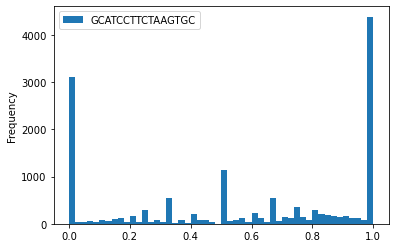

In [21]:
rad.plot.hist(bins=50)

In [22]:
combined_gene = pandas.merge(sfg, tfg, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))

# Compare cell GCATCCTTCTAAGTGC between cellranger and STAR solo gene

<ipython-input-23-3fd4f3200269>:4: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined_gene).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)


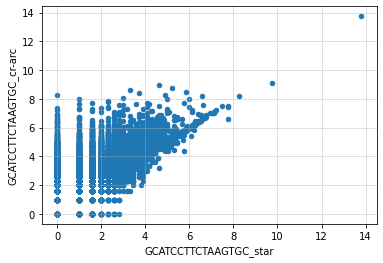

In [23]:
f = pyplot.figure()
ax = f.add_subplot(1,1,1)

p = numpy.log2(combined_gene).plot.scatter(x="{}_star".format(tenx_max_cell), y="{}_cr-arc".format(tenx_max_cell), ax=ax)
#ax.set_xscale('log')
#ax.set_yscale('log')
#ax.set_xlim(0,1e5)
#ax.set_ylim(0,1e5)
ax.grid(alpha=.5)

Wait a second... that looks like cell ranger has higher expression... what did they change? Are they counting introns? Multireads?

In [24]:
gene_cors = compute_spearman_anndata(tenx_common, solo278a_filtered_gene)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Compare per cell gene spearman correlation

There is a warning message from the spearman function complaining that the input matrix has an issue, so this histogram may be incorrect.

<AxesSubplot:ylabel='Frequency'>

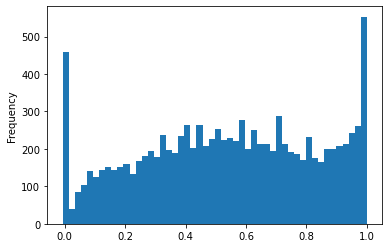

In [25]:
gene_cors.plot.hist(bins=50)

# Prepare GeneFull comparisons

In [26]:
common_genefull_barcodes = [ x for x in tenx_filtered.obs_names if x in set(tenx_filtered.obs_names).intersection(solo278a_genefull.obs_names)]
solo278a_filtered_genefull = solo278a_genefull[common_genefull_barcodes,:]
sfgf = solo278a_filtered_genefull[tenx_max_cell].to_df().T
sfgf.describe()

,GCATCCTTCTAAGTGC
count,36601.000000
mean,5.429824
std,76.578346
min,0.000000
25%,0.000000
50%,0.000000
75%,2.000000
max,14143.000000


In [27]:
combined_genefull = pandas.merge(sfgf, tfg, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))

In [28]:
def plot_cell(star, cr, cell):
    star_cell = star[cell].to_df().T
    cr_cell = cr[cell].to_df().T
    combined = pandas.merge(star_cell, cr_cell, left_index=True, right_index=True, suffixes=("_star", "_cr-arc"))
    f = pyplot.figure()
    ax = f.add_subplot(1,1,1)

    p = numpy.log2(combined).plot.scatter(x="{}_star".format(cell), y="{}_cr-arc".format(cell), ax=ax)
    #ax.set_xscale('log')
    #ax.set_yscale('log')
    #ax.set_xlim(0,1e5)
    #ax.set_ylim(0,1e5)
    ax.grid(alpha=.5)

# Compare cell GCATCCTTCTAAGTGC between cellranger and STAR solo genefull

<ipython-input-28-35c547c9dd5b>:8: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined).plot.scatter(x="{}_star".format(cell), y="{}_cr-arc".format(cell), ax=ax)


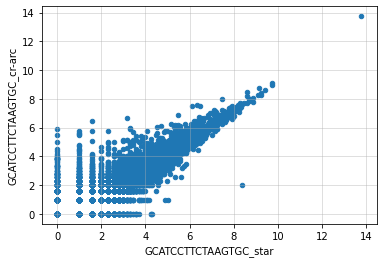

In [29]:
plot_cell(solo278a_filtered_genefull, tenx_filtered, tenx_max_cell)

In [30]:
tenx_common_genefull = tenx_filtered[common_genefull_barcodes,:]
genefull_cors = compute_spearman_anndata(tenx_common_genefull, solo278a_filtered_genefull)

/usr/lib/python3/dist-packages/scipy/stats/stats.py:4264: SpearmanRConstantInputWarning: An input array is constant; the correlation coefficent is not defined.
  warnings.warn(SpearmanRConstantInputWarning())


# Plot GeneFull correlations

<AxesSubplot:ylabel='Frequency'>

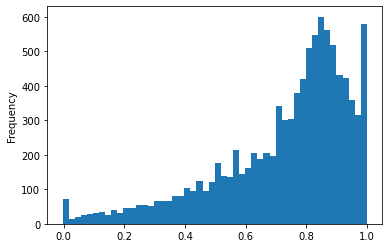

In [31]:
genefull_cors.plot.hist(bins=50)

Well that's an improvement. Looks like they're counting introns.

In [32]:
genefull_cors[(genefull_cors > 0.8) & (genefull_cors < 0.81)]

AACAAGCCAACCCTCC    0.808151
AACAGGATCGGGATTT    0.802919
AACCTAATCCCTGGAA    0.801640
AACCTAATCTTAGCCC    0.807804
AAGAATCAGTGAACAG    0.803913
                      ...   
TTTGACTTCTCACATT    0.806990
TTTGTCCCATGTCAGC    0.803183
TTTGTCTAGGCCAATT    0.806227
TTTGTTGGTAATCACG    0.806600
TTTGTTGGTGAGCAAG    0.809251
Length: 227, dtype: float64

In [33]:
cell_id = genefull_cors[(genefull_cors > 0.8) & (genefull_cors < 0.81)].index[0]

<ipython-input-28-35c547c9dd5b>:8: RuntimeWarning: divide by zero encountered in log2
  p = numpy.log2(combined).plot.scatter(x="{}_star".format(cell), y="{}_cr-arc".format(cell), ax=ax)


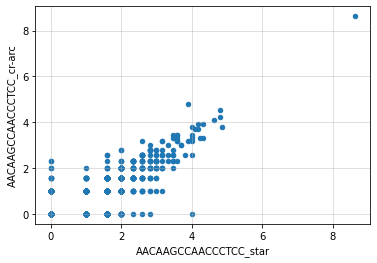

In [34]:
plot_cell(solo278a_filtered_genefull, tenx_filtered, cell_id)

In [63]:
ok_solo_cell = solo278a_filtered_genefull[cell_id].to_df().T
ok_cr_cell = tenx_common_genefull[cell_id].to_df().T

ok_cells = pandas.merge(ok_solo_cell, ok_cr_cell, left_index=True, right_index=True, suffixes=("_solo", "_cr"))

ok_cells.shape

(36601, 2)

In [37]:
different =  (ok_cells['{}_solo'.format(cell_id)] != ok_cells['{}_cr'.format(cell_id)])


In [39]:
ok_cells[different].sort_values(by="{}_solo".format(cell_id))

,AACAAGCCAACCCTCC_solo,AACAAGCCAACCCTCC_cr
ENSG00000229152,0.0,1.0
ENSG00000139436,0.0,1.0
ENSG00000197584,0.0,1.0
ENSG00000135111,0.0,2.0
ENSG00000111786,0.0,1.0
...,...,...
ENSG00000181722,25.0,17.0
ENSG00000099204,28.0,19.0
ENSG00000245532,28.0,23.0
ENSG00000148655,29.0,14.0


In [64]:
ok_cells[different].sort_values(by="{}_cr".format(cell_id))

,AACAAGCCAACCCTCC_solo,AACAAGCCAACCCTCC_cr
ENSG00000131591,1.0,0.0
ENSG00000165119,1.0,0.0
ENSG00000196312,1.0,0.0
ENSG00000196116,1.0,0.0
ENSG00000136937,1.0,0.0
...,...,...
ENSG00000181722,25.0,17.0
ENSG00000099204,28.0,19.0
ENSG00000245532,28.0,23.0
ENSG00000069667,15.0,28.0


In [41]:
store = pandas.HDFStore("/woldlab/loxcyc/home/diane/proj/encode-202006-jamboree-detrout-rna-sc-pipeline/genome/GRCh38-arc2.0-2.7.8a/GRCh38-arc2.0-2.7.8a.h5")
gtf = store["/gtf"]
store.close()

In [84]:
gene_id = "ENSG00000148655"
gene = gtf[(gtf["gene_id"] == gene_id) & (gtf["type"] == "gene")]

In [85]:
ensg = gene.loc[gene.first_valid_index()]

In [54]:
tenx_bam = pysam.AlignmentFile(tenx_root / "outs" / "gex_possorted_bam.bam", "rb")
solo_bam = pysam.AlignmentFile(solo278a_root / "Aligned.sortedByCoord.out.bam", "rb")

In [55]:
tenx_all_reads = list(tenx_bam.fetch(ensg.chromosome, ensg.start, ensg.stop))
solo_all_reads = list(solo_bam.fetch(ensg.chromosome, ensg.start, ensg.stop))
print("Solo len={}, CR len={}".format(len(solo_all_reads), len(tenx_all_reads)))

Solo len=882393, CR len=877946


X_all_reads is everything in this tenx run, so is many libraries and many UMIs.

In [56]:
tenx_cell_id = cell_id + "-1"
tenx_reads = [x for x in tenx_all_reads if x.has_tag("CB") and x.get_tag("CB") == tenx_cell_id]
solo_reads = [x for x in solo_all_reads if x.has_tag("CB") and x.get_tag("CB") == cell_id]
print("Solo len={}, CR len={}".format(len(solo_reads), len(tenx_reads)))

Solo len=53, CR len=53


In [57]:
set([x.query_name for x in tenx_reads]).symmetric_difference([x.query_name for x in solo_reads])

set()

In [60]:
tenx_umis = Counter([x.get_tag("UR") for x in tenx_reads])
len(tenx_umis)

31

In [62]:
solo_umis = Counter([x.get_tag("UR") for x in solo_reads])
len(solo_umis)

31

In [65]:
gene

,chromosome,source,type,start,stop,score,strand,frame,gene_id,gene_version,...,transcript_type,transcript_name,transcript_support_level,havana_transcript,exon_number,exon_id,exon_version,protein_id,ccdsid,ont
1387293,chr10,HAVANA,gene,75431624,76560168,NaN,1,NaN,ENSG00000148655,15,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [92]:
locs = set()
umis_seen = set()
count = 0
for read in tenx_reads:
    if read.is_reverse == False and read.get_tag("UB") not in umis_seen:
        umis_seen.add(read.get_tag("UB"))
        count += 1    
    locs.add((read.reference_name, read.reference_start, read.reference_end, read.is_reverse, read.get_tag("UB")))

print(count, len(solo_reads), ok_cells.loc[gene_id]["{}_cr".format(cell_id)])
sorted(locs)

15 53 14.0


[('chr10', 75447245, 75447335, False, 'TGACAAAACTTA'),
 ('chr10', 75447267, 75447357, False, 'TGACAAAACTTA'),
 ('chr10', 75447302, 75447392, False, 'TGACAAAACTTA'),
 ('chr10', 75447328, 75447418, False, 'TGACAAAACTTA'),
 ('chr10', 75449614, 75449704, True, 'CGACTAGAACGA'),
 ('chr10', 75449628, 75449718, True, 'CGACTAGAACGA'),
 ('chr10', 75483405, 75483465, False, 'AAGAGTACTGAT'),
 ('chr10', 75484017, 75484077, True, 'TGCACATATTCT'),
 ('chr10', 75507399, 75507489, True, 'TTTTATGAGAAC'),
 ('chr10', 75547324, 75547414, False, 'AGACGCACCGTT'),
 ('chr10', 75547462, 75547552, False, 'AGACGCACCGTT'),
 ('chr10', 75577888, 75577978, False, 'ATACCAGTTAGT'),
 ('chr10', 75587774, 75587864, False, 'TCTGCCAGCTCA'),
 ('chr10', 75595660, 75595750, False, 'TACTACCTACCG'),
 ('chr10', 75596653, 75596743, True, 'CCGCTGATCTTT'),
 ('chr10', 75632359, 75632448, False, 'CTACTTAGACTT'),
 ('chr10', 75650544, 75650634, True, 'AGTCCAACTCAC'),
 ('chr10', 75650574, 75650664, True, 'AGTCCAACTCAC'),
 ('chr10', 756506

In [99]:
locs = set()
umis_seen = set()
count = 0
for read in solo_reads:
    locs.add((read.reference_name, read.reference_start, read.reference_end, read.is_reverse, read.get_tag("UR")))
    if read.get_tag("UB") not in umis_seen:
        umis_seen.add(read.get_tag("UB"))
        count += 1   
print(count, len(solo_reads), ok_cells.loc[gene_id]["{}_solo".format(cell_id)])
sorted(locs)

31 53 29.0


[('chr10', 75447245, 75447335, False, 'TGACAAAACTTA'),
 ('chr10', 75447267, 75447357, False, 'TGACAAAACTTA'),
 ('chr10', 75447302, 75447392, False, 'TGACAAAACTTA'),
 ('chr10', 75447328, 75447418, False, 'TGACAAAACTTA'),
 ('chr10', 75449614, 75449704, True, 'CGACTAGAACGA'),
 ('chr10', 75449628, 75449718, True, 'CGACTAGAACGA'),
 ('chr10', 75483405, 75483465, False, 'AAGAGTACTGAT'),
 ('chr10', 75484017, 75484077, True, 'TGCACATATTCT'),
 ('chr10', 75507399, 75507489, True, 'TTTTATGAGAAC'),
 ('chr10', 75547324, 75547414, False, 'AGACGCACCGTT'),
 ('chr10', 75547462, 75547552, False, 'AGACGCACCGTT'),
 ('chr10', 75577888, 75577978, False, 'ATACCAGTTAGT'),
 ('chr10', 75587774, 75587864, False, 'TCTGCCAGCTCA'),
 ('chr10', 75595660, 75595750, False, 'TACTACCTACCG'),
 ('chr10', 75596653, 75596743, True, 'CCGCTGATCTTT'),
 ('chr10', 75632359, 75632448, False, 'CTACTTAGACTT'),
 ('chr10', 75650544, 75650634, True, 'AGTCCAACTCAC'),
 ('chr10', 75650574, 75650664, True, 'AGTCCAACTCAC'),
 ('chr10', 756506

In [82]:
ok_cells

,AACAAGCCAACCCTCC_solo,AACAAGCCAACCCTCC_cr
ENSG00000243485,0.0,0.0
ENSG00000237613,0.0,0.0
ENSG00000186092,0.0,0.0
ENSG00000238009,0.0,0.0
ENSG00000239945,0.0,0.0
...,...,...
ENSG00000277836,0.0,0.0
ENSG00000278633,0.0,0.0
ENSG00000276017,0.0,0.0
ENSG00000278817,0.0,0.0
